# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

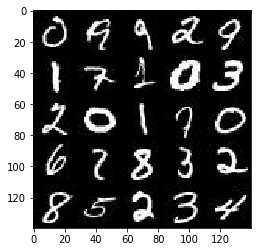

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

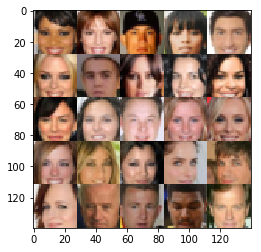

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    ireal = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels],name="input_real")
    iz = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return ireal, iz, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [16]:
def leak_relu(x, alpha=0.1, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)
def discriminator(images, reuse=False, keep_prob=0.9):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding="SAME", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.nn.dropout(x1, keep_prob)
        relu1 = leak_relu(x1, alpha, name='leaky_relu1')

        x2 = tf.layers.conv2d(x1, 128, 3, strides=1, padding="SAME", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.nn.dropout(x2, keep_prob)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leak_relu(bn2, alpha, name='leaky_relu2')

        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding="SAME", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.nn.dropout(x3, keep_prob)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leak_relu(bn3, alpha, name='leaky_relu3')
        flat = tf.reshape(relu3, [-1, 7*7*256])
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        x1 = tf.layers.dense(z, 7 * 7 * 512)

        x1 = tf.reshape(x1, [-1, 7, 7, 512])
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = leak_relu(bn1, alpha, name='leaky_relu1')
        

        x2 = tf.layers.conv2d_transpose(relu1, 64, 3, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = leak_relu(bn2, alpha, name='leaky_relu2')


        # output layer
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 3, strides=2, padding='SAME')

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)


    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
import pickle as pkl
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    
    steps = 0
    samples, losses = [], []
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, 1 if data_image_mode=='L' else 3)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                #Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images * (2.0/(np.max(batch_images) - np.min(batch_images))),input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z})
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real:batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z:batch_z, input_real:batch_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 60 == 0:
                    show_generator_output(sess, 16, input_z, 1 if data_image_mode=='L' else 3, data_image_mode)

    print("Training done!")
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.1096... Generator Loss: 4.0040
Epoch 1/2... Discriminator Loss: 1.8989... Generator Loss: 0.5212
Epoch 1/2... Discriminator Loss: 2.0258... Generator Loss: 1.0743


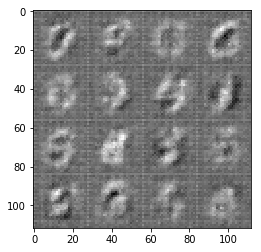

Epoch 1/2... Discriminator Loss: 2.1728... Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 2.0885... Generator Loss: 0.6420
Epoch 1/2... Discriminator Loss: 2.1782... Generator Loss: 0.5553


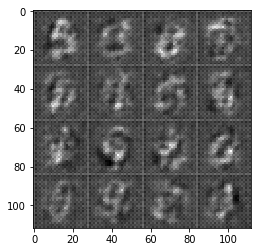

Epoch 1/2... Discriminator Loss: 2.4615... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 2.7432... Generator Loss: 0.4439
Epoch 1/2... Discriminator Loss: 4.9984... Generator Loss: 2.7315


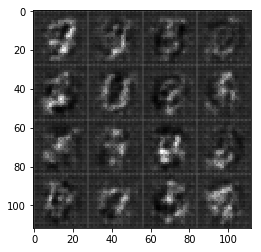

Epoch 1/2... Discriminator Loss: 4.2609... Generator Loss: 1.6482
Epoch 1/2... Discriminator Loss: 3.9876... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 4.6268... Generator Loss: 1.8161


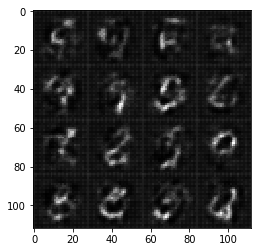

Epoch 1/2... Discriminator Loss: 5.0900... Generator Loss: 2.2388
Epoch 1/2... Discriminator Loss: 4.1128... Generator Loss: 1.1684
Epoch 1/2... Discriminator Loss: 4.2271... Generator Loss: 1.0817


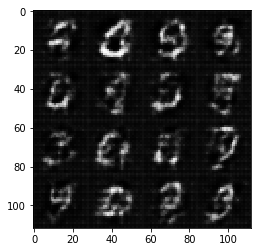

Epoch 1/2... Discriminator Loss: 4.0813... Generator Loss: 1.2931
Epoch 1/2... Discriminator Loss: 4.2464... Generator Loss: 1.3226
Epoch 1/2... Discriminator Loss: 3.2296... Generator Loss: 0.7079


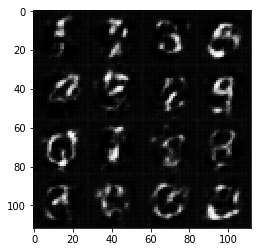

Epoch 1/2... Discriminator Loss: 5.0807... Generator Loss: 2.5184
Epoch 1/2... Discriminator Loss: 4.1774... Generator Loss: 1.5085
Epoch 1/2... Discriminator Loss: 3.6230... Generator Loss: 1.1254


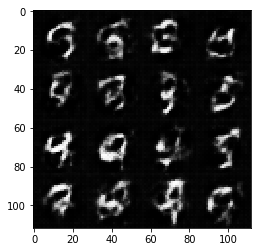

Epoch 1/2... Discriminator Loss: 3.9667... Generator Loss: 1.2442
Epoch 1/2... Discriminator Loss: 4.7189... Generator Loss: 2.4435
Epoch 1/2... Discriminator Loss: 3.4190... Generator Loss: 0.8197


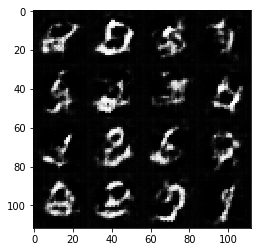

Epoch 1/2... Discriminator Loss: 3.9493... Generator Loss: 1.4713
Epoch 1/2... Discriminator Loss: 5.0267... Generator Loss: 2.5868
Epoch 1/2... Discriminator Loss: 3.3169... Generator Loss: 0.9242


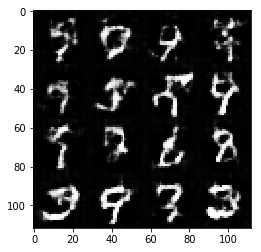

Epoch 1/2... Discriminator Loss: 3.7884... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 3.3746... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 3.7291... Generator Loss: 0.7253


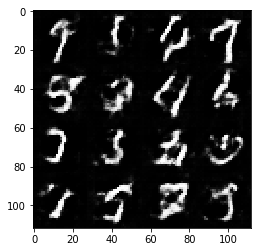

Epoch 1/2... Discriminator Loss: 4.2758... Generator Loss: 1.8651
Epoch 1/2... Discriminator Loss: 3.4465... Generator Loss: 0.6715
Epoch 1/2... Discriminator Loss: 4.8457... Generator Loss: 2.1134


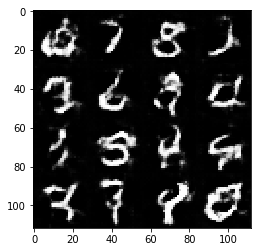

Epoch 1/2... Discriminator Loss: 4.3175... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 4.1726... Generator Loss: 1.2801
Epoch 1/2... Discriminator Loss: 4.5015... Generator Loss: 1.5504


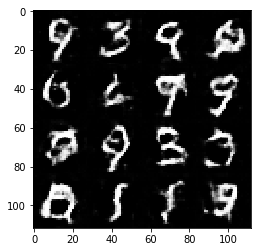

Epoch 1/2... Discriminator Loss: 4.2406... Generator Loss: 1.2272
Epoch 1/2... Discriminator Loss: 4.8275... Generator Loss: 1.9280
Epoch 1/2... Discriminator Loss: 3.9706... Generator Loss: 1.0701


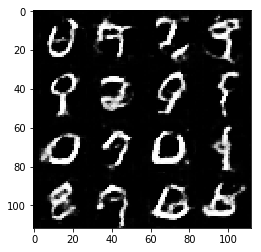

Epoch 1/2... Discriminator Loss: 4.0730... Generator Loss: 1.1662
Epoch 1/2... Discriminator Loss: 4.2593... Generator Loss: 1.6330
Epoch 1/2... Discriminator Loss: 3.7172... Generator Loss: 0.5091


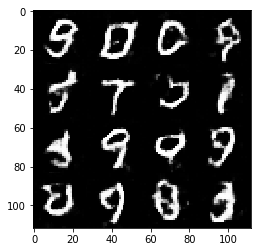

Epoch 1/2... Discriminator Loss: 3.6505... Generator Loss: 0.8664
Epoch 1/2... Discriminator Loss: 4.5655... Generator Loss: 2.0461
Epoch 1/2... Discriminator Loss: 5.0440... Generator Loss: 1.7791


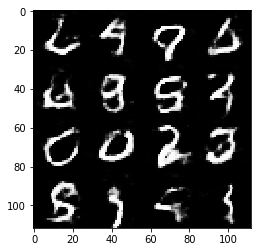

Epoch 1/2... Discriminator Loss: 4.7218... Generator Loss: 2.0320
Epoch 2/2... Discriminator Loss: 3.9559... Generator Loss: 1.2136
Epoch 2/2... Discriminator Loss: 3.5404... Generator Loss: 0.8358


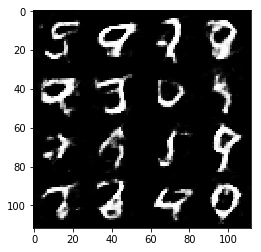

Epoch 2/2... Discriminator Loss: 4.3420... Generator Loss: 1.1746
Epoch 2/2... Discriminator Loss: 5.0947... Generator Loss: 2.0480
Epoch 2/2... Discriminator Loss: 3.0578... Generator Loss: 0.6593


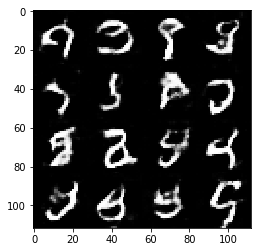

Epoch 2/2... Discriminator Loss: 3.2207... Generator Loss: 0.6817
Epoch 2/2... Discriminator Loss: 4.3934... Generator Loss: 1.7251
Epoch 2/2... Discriminator Loss: 4.1059... Generator Loss: 1.1934


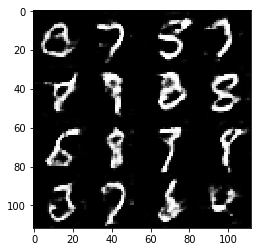

Epoch 2/2... Discriminator Loss: 3.4831... Generator Loss: 0.8982
Epoch 2/2... Discriminator Loss: 3.9404... Generator Loss: 1.5963
Epoch 2/2... Discriminator Loss: 3.1841... Generator Loss: 0.3599


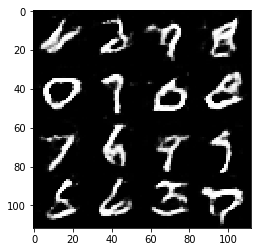

Epoch 2/2... Discriminator Loss: 2.7277... Generator Loss: 0.6313
Epoch 2/2... Discriminator Loss: 3.2144... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 2.9535... Generator Loss: 0.6483


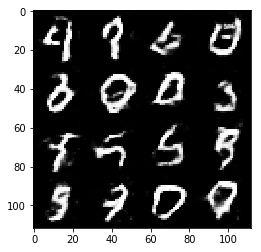

Epoch 2/2... Discriminator Loss: 3.1029... Generator Loss: 0.9239
Epoch 2/2... Discriminator Loss: 3.3031... Generator Loss: 0.9562
Epoch 2/2... Discriminator Loss: 3.5047... Generator Loss: 1.1800


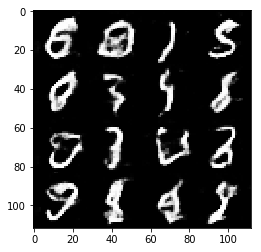

Epoch 2/2... Discriminator Loss: 3.0810... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 4.0951... Generator Loss: 1.8058
Epoch 2/2... Discriminator Loss: 2.7759... Generator Loss: 0.4224


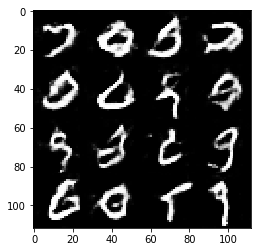

Epoch 2/2... Discriminator Loss: 2.9144... Generator Loss: 0.5782
Epoch 2/2... Discriminator Loss: 2.9609... Generator Loss: 0.6889
Epoch 2/2... Discriminator Loss: 3.1384... Generator Loss: 0.6885


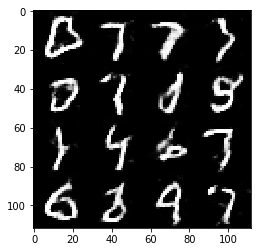

Epoch 2/2... Discriminator Loss: 3.2161... Generator Loss: 1.2478
Epoch 2/2... Discriminator Loss: 2.9261... Generator Loss: 0.8981
Epoch 2/2... Discriminator Loss: 4.1877... Generator Loss: 1.9452


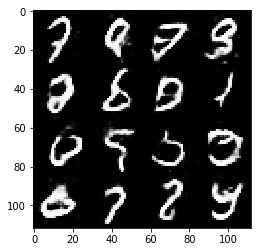

Epoch 2/2... Discriminator Loss: 4.1268... Generator Loss: 1.9790
Epoch 2/2... Discriminator Loss: 2.6531... Generator Loss: 0.5099
Epoch 2/2... Discriminator Loss: 3.8761... Generator Loss: 1.8839


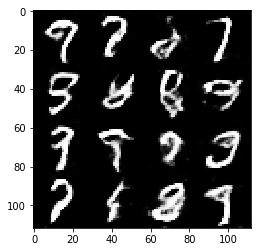

Epoch 2/2... Discriminator Loss: 3.0524... Generator Loss: 0.8647
Epoch 2/2... Discriminator Loss: 3.1247... Generator Loss: 0.5767
Epoch 2/2... Discriminator Loss: 2.7573... Generator Loss: 0.8252


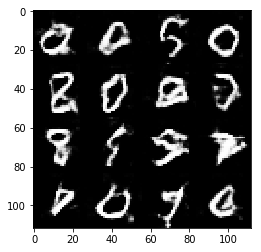

Epoch 2/2... Discriminator Loss: 3.2333... Generator Loss: 1.9596
Epoch 2/2... Discriminator Loss: 2.9413... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 4.0052... Generator Loss: 1.7943


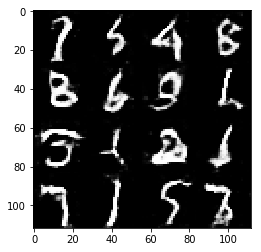

Epoch 2/2... Discriminator Loss: 3.0819... Generator Loss: 1.0488
Epoch 2/2... Discriminator Loss: 2.9988... Generator Loss: 0.8388
Epoch 2/2... Discriminator Loss: 3.1006... Generator Loss: 1.5868


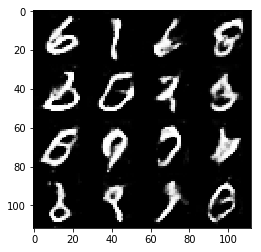

Epoch 2/2... Discriminator Loss: 2.5354... Generator Loss: 0.4059
Epoch 2/2... Discriminator Loss: 3.2181... Generator Loss: 0.9941
Epoch 2/2... Discriminator Loss: 2.8684... Generator Loss: 0.3353


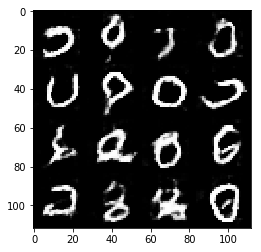

Epoch 2/2... Discriminator Loss: 2.9246... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 2.9001... Generator Loss: 0.7484
Epoch 2/2... Discriminator Loss: 2.6501... Generator Loss: 0.7913


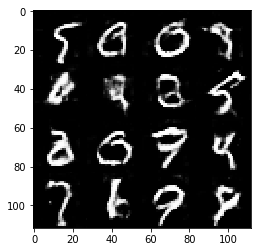

Epoch 2/2... Discriminator Loss: 3.3770... Generator Loss: 1.6057
Epoch 2/2... Discriminator Loss: 2.7619... Generator Loss: 1.0342
Epoch 2/2... Discriminator Loss: 3.3509... Generator Loss: 1.1721


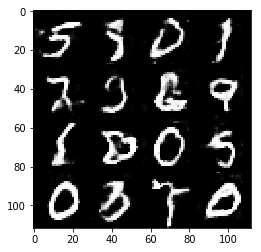

Training done!
CPU times: user 3min 13s, sys: 55.4 s, total: 4min 8s
Wall time: 6min 15s


In [23]:
%%time
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 2.1452
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.5470
Epoch 1/1... Discriminator Loss: 5.2002... Generator Loss: 6.3477


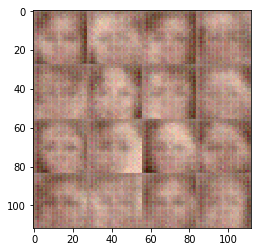

Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 1.9717
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 2.0254... Generator Loss: 0.3522


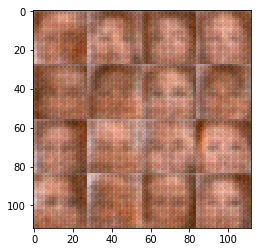

Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 1.5347
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 2.3617


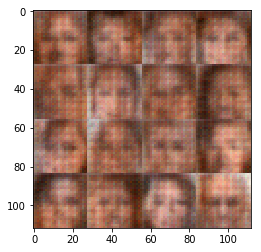

Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 3.7313
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 2.5641
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.7507


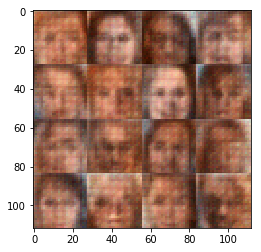

Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 1.8349
Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 1.4007
Epoch 1/1... Discriminator Loss: 0.7135... Generator Loss: 1.4106


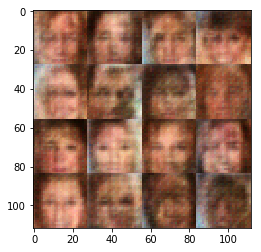

Epoch 1/1... Discriminator Loss: 0.5488... Generator Loss: 6.9135
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 2.1184


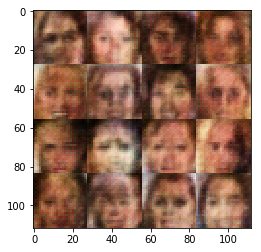

Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 0.4543... Generator Loss: 4.0853
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.5696


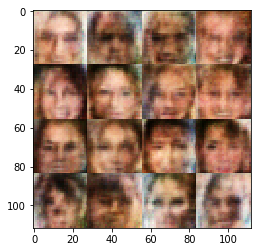

Epoch 1/1... Discriminator Loss: 0.4336... Generator Loss: 5.4516
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 6.1765
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 4.8578


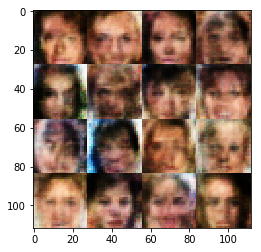

Epoch 1/1... Discriminator Loss: 0.4501... Generator Loss: 3.6784
Epoch 1/1... Discriminator Loss: 0.7986... Generator Loss: 2.3477
Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 2.6990


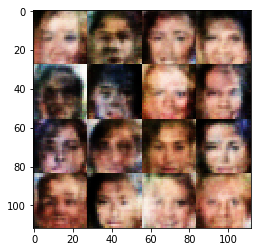

Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 2.2899
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 2.4137
Epoch 1/1... Discriminator Loss: 0.3945... Generator Loss: 5.3550


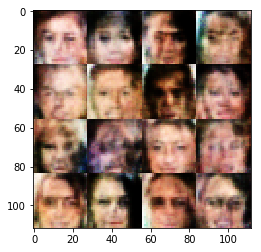

Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 3.0956
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 3.8637
Epoch 1/1... Discriminator Loss: 0.4682... Generator Loss: 4.6230


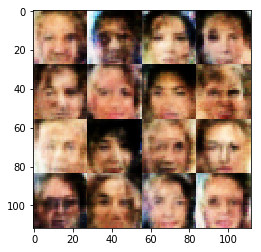

Epoch 1/1... Discriminator Loss: 0.6374... Generator Loss: 3.8309
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 2.3488
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 2.5552


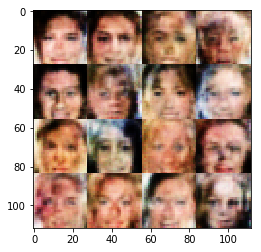

Epoch 1/1... Discriminator Loss: 1.7201... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.4951
Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 4.1883


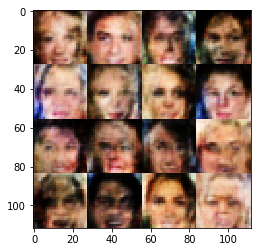

Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.6160
Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 4.6931
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.8614


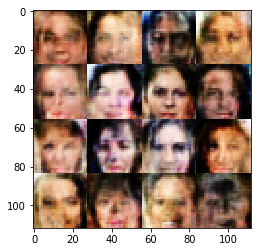

Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 2.1291
Training done!
CPU times: user 2min 20s, sys: 24.2 s, total: 2min 44s
Wall time: 3min 21s


In [24]:
%%time
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.